In [2]:
import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn import preprocessing
import numpy as np
from sklearn.svm import SVC


In [3]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow_datasets as tfds
mnist_data, mnist_info = tfds.load(name='mnist', with_info=True)


In [5]:
pip install tensorflow-datasets


Note: you may need to restart the kernel to use updated packages.


In [6]:
mnist_data, mnist_info = tfds.load(name='mnist', with_info=True)
train_data, test_data = mnist_data['train'], mnist_data['test']


In [7]:
# Define a function to extract HOG features
def extract_hog_features(data):
    list_hog_ft = []
    for feature in data:
        # Convert the image to a NumPy array and reshape it to 28x28
        image = feature['image'].numpy().reshape((28, 28))
        # Extract HOG features from the image
        ft = hog(image, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
        list_hog_ft.append(ft)
    return np.array(list_hog_ft, dtype=np.float64)


In [8]:
# Extract HOG features from training and test data
hog_train_features = extract_hog_features(train_data)
hog_test_features = extract_hog_features(test_data)

In [9]:
# Load the labels
train_labels = np.array([feature['label'].numpy() for feature in train_data])
test_labels = np.array([feature['label'].numpy() for feature in test_data])


In [10]:
# Create an SVM classifier
clf = SVC(C=5, gamma=0.05)

In [11]:
clf.fit(hog_train_features, train_labels)

SVC(C=5, gamma=0.05)

In [12]:
# Calculate the accuracy score on the test set
accuracy = clf.score(hog_test_features, test_labels)
print("Accuracy:", accuracy)


Accuracy: 0.8918


In [13]:
list_hog_ft = []
for feature in mnist_data['train']:
    ft = hog(feature['image'].numpy().reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
    list_hog_ft.append(ft)
hog_features = np.array(list_hog_ft, 'float64')
# Define pp
pp = preprocessing.StandardScaler().fit(hog_features)

joblib.dump((clf, pp), "digits_cls1.pkl", compress=3)


['digits_cls1.pkl']

In [4]:
# Import the modules
import cv2
import joblib
from skimage.feature import hog
import numpy as np


In [5]:
# Load the classifier
clf,pp = joblib.load("digits_cls1.pkl")

In [6]:
# Load the image
im = cv2.imread(r'C:\Users\palak\Downloads\photo_1.jpg')

# Check if the image is loaded correctly
if im is None:
    print("Error: Unable to load image.")
else:
    print("Image loaded successfully.")


Image loaded successfully.


In [7]:
# Convert to grayscale and apply Gaussian filtering
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

In [8]:
# Threshold the image
ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
if cv2.__version__.startswith('4'):
    ctrs, _ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    _, ctrs, _ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [9]:
# Get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]

In [10]:
for rect in rects:
    # Draw the rectangles
    cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3) 
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    # Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1))
    roi_hog_fd = pp.transform(np.array([roi_hog_fd], 'float64'))
    # Pridict digit
    nbr = clf.predict(roi_hog_fd)
    cv2.putText(im, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)

In [11]:
# Resize the image
resized_im = cv2.resize(im, (800, 600))  # Adjust the dimensions as needed


In [12]:
# Convert to grayscale
gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Resize the grayscale image
resized_gray_im = cv2.resize(gray_im, (800, 600))  # Adjust the dimensions as needed


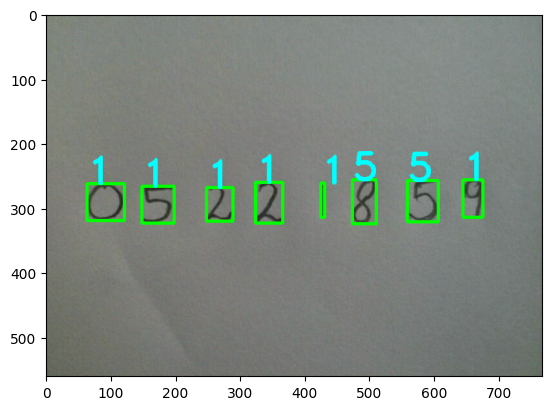

In [13]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.show()


In [1]:
import cv2
import joblib
from skimage.feature import hog
import numpy as np


In [2]:
# Load the classifier
clf, pp = joblib.load("digits_cls1.pkl")

In [3]:
def main():  
    # Open Camera
    cap = cv2.VideoCapture(0)

    while (cap.isOpened()):
        # Capture frames from the camera
        ret, img = cap.read()
        # Apply get_img_contour_thresh function on frame
        img, contours, thresh = get_img_contour_thresh(img)
        ans = ''
        
        if len(contours) > 0:
            # Find contour with maximum area
            contour = max(contours, key=cv2.contourArea)
            # Ranging contourArea
            if cv2.contourArea(contour) > 1500 and cv2.contourArea(contour)<5000 :
                # Dimensions of rectangle
                x, y, w, h = cv2.boundingRect(contour)
                # Making new image containing coutour for classification
                newImage = thresh[y:y + h, x:x + w]
                # Resize new image
                newImage = cv2.resize(newImage, (28, 28))
                newImage = np.array(newImage)
                # Perform classification
                hog_ft = hog(newImage, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1))

                hog_ft = pp.transform(np.array([hog_ft], 'float64'))
                ans = clf.predict(hog_ft)
               
                
                
        # Make the rectangular region of size x, y, w, h and texting classified digit        
        x, y, w, h = 0, 0, 300, 300
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, "svm : " + str(ans), (10, 320),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        #Showing frame and threshold
        cv2.imshow("Frame", img)
        cv2.imshow("Contours", thresh)
        k = cv2.waitKey(10)
        if k == 27:
            break
            
def get_img_contour_thresh(img):
    x, y, w, h = 0, 0, 300, 300
    
    # Change color-space from BGR -> Gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur and Threshold
    blur = cv2.GaussianBlur(gray, (35, 35), 0)
    ret, thresh = cv2.threshold(blur, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Making thresh image of size x, y, w, h = 0, 0, 300, 300
    thresh = thresh[y:y + h, x:x + w]
    
    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    return img, contours, thresh

In [ ]:
main()